In [417]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = 100
%matplotlib inline

In [418]:
training_data = pd.DataFrame.from_csv('train.csv')
test_data = pd.DataFrame.from_csv('test.csv')
target = 'SalePrice'

In [419]:
training_data_end_idx = len(training_data)
test_data_start_idx = len(training_data)

In [420]:
data = pd.concat([training_data, test_data])

In [421]:
data.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
Id                                                                        
1        856       854          0   NaN             3     1Fam       TA   
2       1262         0          0   NaN             3     1Fam       TA   
3        920       866          0   NaN             3     1Fam       TA   
4        961       756          0   NaN             3     1Fam       Gd   
5       1145      1053          0   NaN             4     1Fam       TA   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2 BsmtFinType1 BsmtFinType2  \
Id                                                                  
1            No         706           0          GLQ          Unf   
2            Gd         978           0          ALQ          Unf   
3            Mn         486           0          GLQ          Unf   
4            No         216           0          ALQ          Unf   
5            Av         655           0          GLQ          Unf   

    BsmtFullBath  BsmtHalfBath BsmtQual  BsmtUnfSF CentralAir Condition1  \
Id                                                                         
1              1             0       Gd        150          Y       Norm   
2              0             1       Gd        284          Y      Feedr   
3              1             0       Gd        434          Y       Norm   
4              1             0       TA        540          Y       Norm   
5              1             0       Gd        490          Y       Norm   

   Condition2 Electrical  EnclosedPorch ExterCond ExterQual Exterior1st  \
Id                                                                        
1        Norm      SBrkr              0        TA        Gd     VinylSd   
2        Norm      SBrkr              0        TA        TA     MetalSd   
3        Norm      SBrkr              0        TA        Gd     VinylSd   
4        Norm      SBrkr            272        TA        TA     Wd Sdng   
5        Norm      SBrkr              0        TA        Gd     VinylSd   

   Exterior2nd Fence FireplaceQu  Fireplaces Foundation  FullBath Functional  \
Id                                                                             
1      VinylSd   NaN         NaN           0      PConc         2        Typ   
2      MetalSd   NaN          TA           1     CBlock         2        Typ   
3      VinylSd   NaN          TA           1      PConc         2        Typ   
4      Wd Shng   NaN          Gd           1     BrkTil         1        Typ   
5      VinylSd   NaN          TA           1      PConc         2        Typ   

    GarageArea  GarageCars GarageCond GarageFinish GarageQual GarageType  \
Id                                                                         
1          548           2         TA          RFn         TA     Attchd   
2          460           2         TA          RFn         TA     Attchd   
3          608           2         TA          RFn         TA     Attchd   
4          642           3         TA          Unf         TA     Detchd   
5          836           3         TA          RFn         TA     Attchd   

    GarageYrBlt  GrLivArea  HalfBath Heating HeatingQC HouseStyle  \
Id                                                                  
1          2003       1710         1    GasA        Ex     2Story   
2          1976       1262         0    GasA        Ex     1Story   
3          2001       1786         1    GasA        Ex     2Story   
4          1998       1717         0    GasA        Gd     2Story   
5          2000       2198         1    GasA        Ex     2Story   

    KitchenAbvGr KitchenQual LandContour LandSlope  LotArea LotConfig  \
Id                                                                      
1              1          Gd         Lvl       Gtl     8450    Inside   
2              1          TA         Lvl       Gtl     9600       FR2   
3              1          Gd         Lvl       Gtl    11250    In

Data pre-process
1) We first need to handle categorical data, the way to check if a variable is categorical data or numerical data is to check its data type and see if it's object, one thing to note is that we need to be cautious about date variable, even they are numerical variables we still need to regard them as categorical variable.
2) Then we need to handle missing data, there are many strategies we can use, to keep it simple, we fill na value with the corresponding mean value, that is, for any missing feature in the dataset, we use that's feature's mean valua as replacement.
3) Normalize data. It's always a good habit to normalize data before training any regression model
http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [422]:
# Extract categorical data
categorical_variables = []
continuous_variables = []
for col in data.columns:
    if data[col].dtype == object or 'yr' in col.lower() or 'year' in col.lower():
        categorical_variables.append(col)
    elif col != target:
        continuous_variables.append(col)
        
data[categorical_variables] = data[categorical_variables].astype(object)

In [423]:
# Get dummy dataframe by using pandas.get_dumies() functions
dummy_df = pd.get_dummies(data[categorical_variables], dummy_na=True)

In [424]:
# Combine dataset and remove original categorical variable columns
data = pd.concat([data, dummy_df], axis=1)
for col in categorical_variables:
    del data[col]

In [425]:
features = data.columns.values.tolist()
features.remove(target)

Take a look at NA values first

In [426]:
# Take a lo
for col in features:
    num_nulls = len(data[data[col].isnull()])
    if num_nulls != 0:
        print('Feature {} has {} NAN values, out of {} data points.'.format(col, num_nulls, len(data)))

Feature BsmtFinSF1 has 1 NAN values, out of 2919 data points.
Feature BsmtFinSF2 has 1 NAN values, out of 2919 data points.
Feature BsmtFullBath has 2 NAN values, out of 2919 data points.
Feature BsmtHalfBath has 2 NAN values, out of 2919 data points.
Feature BsmtUnfSF has 1 NAN values, out of 2919 data points.
Feature GarageArea has 1 NAN values, out of 2919 data points.
Feature GarageCars has 1 NAN values, out of 2919 data points.
Feature LotFrontage has 486 NAN values, out of 2919 data points.
Feature MasVnrArea has 23 NAN values, out of 2919 data points.
Feature TotalBsmtSF has 1 NAN values, out of 2919 data points.


The dataset is not that bad, only few missing data, so filling these values with mean value won't have a significant influence on the dataset

In [427]:
data[features] = data[features].fillna(data.mean())

Normalize dataset, make all the features in the same scale, with mean 0 and standard deviation 1, note we only need to normalize numerical data.

In [428]:
data[continuous_variables] = (data[continuous_variables] - data[continuous_variables].mean()) / data[continuous_variables].std(ddof=0)

Dataset is ready at this stage, two regression models I'd like to play here, Lasso and Ridge.

The biggest difference between Lasso and Ridge is the different strategy they use to avoid over-fitting, they have the same target function, but their model complexity measure

In [328]:
X_train = data[:training_data_end_idx][features]
X_test = data[test_data_start_idx:][features]
y = data[:training_data_end_idx]['SalePrice']

In [302]:
# Feature selection
coefs = []
for l1_penalty in [1, 3, 5, 10, 15, 30, 50, 70,100,150,250]:
    print('Training model with l1_penalty {}'.format(l1_penalty))
    error = np.sqrt(-cross_val_score(linear_model.Lasso(alpha=l1_penalty, max_iter=1000000), X_train, y, scoring="neg_mean_squared_error", cv=5)).mean()
    coefs.append(tuple((l1_penalty, error)))

Training model with l1_penalty 1
Training model with l1_penalty 3
Training model with l1_penalty 5
Training model with l1_penalty 10
Training model with l1_penalty 15
Training model with l1_penalty 30
Training model with l1_penalty 50
Training model with l1_penalty 70
Training model with l1_penalty 100
Training model with l1_penalty 150
Training model with l1_penalty 250


In [303]:
alphas = [x[0] for x in coefs]
errors = [x[1] for x in coefs]

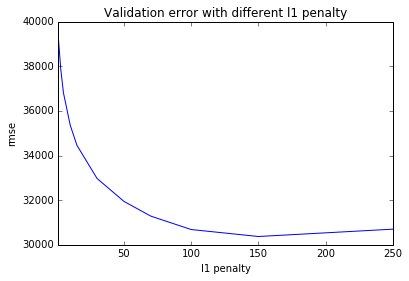

In [304]:
errors = pd.Series(errors, index=alphas)
errors.plot(title='Validation error with different l1 penalty')
plt.xlabel('l1 penalty')
plt.ylabel('rmse')

In [305]:
# Best penalty = 150

In [306]:
lasso_model = linear_model.Lasso(alpha=150)
lasso_model.fit(X_train, y)

Lasso(alpha=150, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [307]:
lasso_coef = pd.Series(lasso_model.coef_, index = features)

In [308]:
print("Lasso picked " + str(sum(lasso_coef != 0)) + " variables and eliminated the other " +  str(sum(lasso_coef == 0)) + " variables")

Lasso picked 112 variables and eliminated the other 506 variables


In [320]:
# A deep look into the selected features
imp_coef = pd.concat([lasso_coef.sort_values().head(10),
                      lasso_coef.sort_values().tail(10)])

In [336]:
imp_coef

RoofMatl_ClyTile        -257211.433328
Condition2_PosN          -57095.268143
Neighborhood_Edwards      -9620.741570
LandContour_Bnk           -9188.447564
GarageYrBlt_2007.0        -7388.711592
MSSubClass                -6539.008959
BsmtExposure_No           -5805.775297
SaleCondition_Abnorml     -5437.839268
ExterQual_TA              -5150.110578
Neighborhood_OldTown      -5049.249796
Neighborhood_Crawfor      13622.179965
OverallQual               13779.500800
BsmtExposure_Gd           15915.388456
GrLivArea                 22613.153509
Neighborhood_NridgHt      23705.096579
BsmtQual_Ex               24239.867016
KitchenQual_Ex            24954.828593
Neighborhood_StoneBr      33097.596112
RoofMatl_WdShngl          34527.602970
Neighborhood_NoRidge      37498.115659
dtype: float64

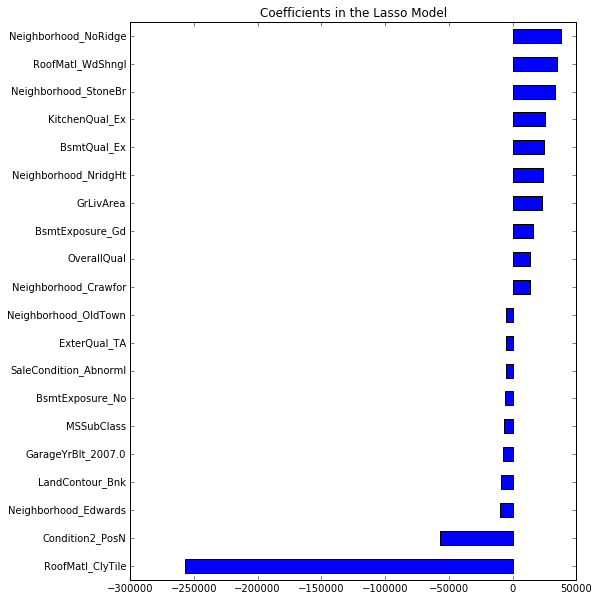

In [321]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [343]:
# Neighborhood_NoRidge
# Neighborhood: Physical locations within Ames city limits
# NoRidge	North ridge
training_data.groupby(['Neighborhood'])['SalePrice'].mean().sort_values(ascending=False).head(5)

Neighborhood
NoRidge    335295
NridgHt    316270
StoneBr    310499
Timber     242247
Veenker    238772
Name: SalePrice, dtype: int64

In [342]:
# We see that indeed the house prices in NoRidge area have highest average
# price.
# Let's take a look at the second most positive coefficient, RoofMatl_WdShngl
# RoofMatl: Roof material
# WdShake	Wood Shakes

training_data.groupby(['RoofMatl'])['SalePrice'].mean().sort_values(ascending=False)

RoofMatl
WdShngl    390250
Membran    241500
WdShake    241400
Tar&Grv    185406
Metal      180000
CompShg    179803
ClyTile    160000
Roll       137000
Name: SalePrice, dtype: int64

In [345]:
# Again, we see that houses with WdShngl roof have highest average prices!
# Also note that RoofMatl_ClyTile has the most negative coefficient and
# the houses with this roof material have the second lowest house prices.

In [346]:
# So, we think our feature selection results are reasonable
important_features = [features[i] for i in np.where(model.coef_ != 0)[0]]

In [351]:
# Before we go to Ridge regression, let's take a look at the training error
lasso_training_error = mean_squared_error(y, model.predict(X_train))**0.5

In [352]:
lasso_training_error

24291.600488337554

In [353]:
# Now, let's try to train a Ridge regression model

In [370]:
# Find the best l2_penalty
coefs = []
for l2_penalty in [0.01, 0.5, 0.3, 1, 3, 5, 10, 15, 30, 50, 70,100,150,250]:
    print('Training model with l2_penalty {}'.format(l2_penalty))
    error = np.sqrt(-cross_val_score(linear_model.Ridge(alpha=l2_penalty), X_train, y, scoring="neg_mean_squared_error", cv=5)).mean()
    coefs.append(tuple((l2_penalty, error)))

Training model with l2_penalty 0.01
Training model with l2_penalty 0.5
Training model with l2_penalty 0.3
Training model with l2_penalty 1
Training model with l2_penalty 3
Training model with l2_penalty 5
Training model with l2_penalty 10
Training model with l2_penalty 15
Training model with l2_penalty 30
Training model with l2_penalty 50
Training model with l2_penalty 70
Training model with l2_penalty 100
Training model with l2_penalty 150
Training model with l2_penalty 250


In [371]:
alphas = [x[0] for x in coefs]
errors = [x[1] for x in coefs]

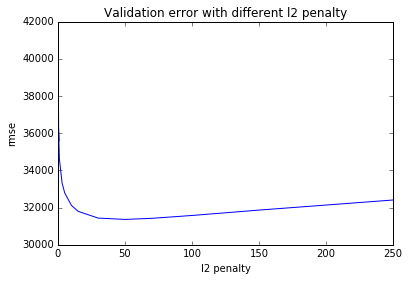

In [372]:
errors = pd.Series(errors, index=alphas)
errors.plot(title='Validation error with different l2 penalty')
plt.xlabel('l2 penalty')
plt.ylabel('rmse')

In [401]:
best_l2_penalty = errors.sort_values().head(1).index.values[0]

In [402]:
ridge_model = linear_model.Ridge(alpha=best_l2_penalty)
ridge_model.fit(X_train, y)

Ridge(alpha=50.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [405]:
ridge_coef = pd.Series(ridge_model.coef_, index = features)

In [410]:
imp_coef = pd.concat([ridge_coef.sort_values().head(10),
                      ridge_coef.sort_values().tail(10)])

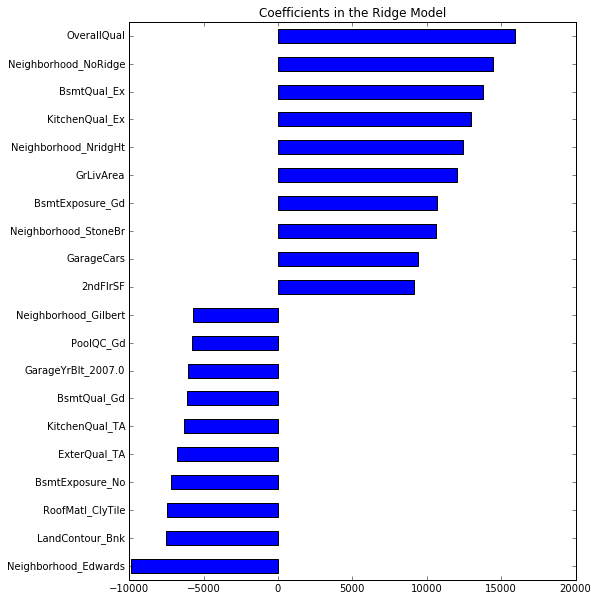

In [411]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [ ]:
# As you can see, Ridge regression gave more weights to OverallQual than 
# Lasso regression, 

In [403]:
ridge_training_error = mean_squared_error(y, ridge_model.predict(X_train))**0.5

In [404]:
ridge_training_error

26546.945864614161

In [ ]:
ridge_coef = pd.Series(model.coef_, index = features)